```{admonition} Lecture Materials
:class: tip
[Download the slide deck for this lecture](/_static/pdf/Lecture10-NumericalDerivatives.pdf)
```

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# Automatic differentiation

## Method

**Automatic differentiation** (also known as algorithmic differentiation) is a powerful computational technique for calculating derivatives of functions that are specified as computer programs. Unlike numerical differentiation methods that use finite differences, automatic differentiation computes derivatives with machine precision, without truncation or round-off errors.

Automatic differentiation is based on the fundamental observation that every computer calculation, no matter how complex, ultimately executes a sequence of:

- **Elementary arithmetic operations** (addition, subtraction, multiplication, division)
- **Elementary functions** (exponential, logarithm, trigonometric functions, etc.)

For each of these basic operations, the derivatives are well-known and can be computed exactly.
This allows us to compute the derivatives of any function specified as a computer program by applying the **chain rule**, by viewing any computer calculation as evaluating a composite function:

$$y = f(g(h(x)))$$

### Computational Process

1. **Forward evaluation**: The function is evaluated step by step, with intermediate values stored:

   $$y = f(g(h(x))) = f(g(h(w_0))) = f(g(w_1)) = f(w_2) = w_3$$

2. **Derivative calculation**: The derivative is computed by applying the chain rule:

   $$\frac{\partial y}{\partial x} = \frac{\partial y}{\partial w_2} \frac{\partial w_2}{\partial w_1} \frac{\partial w_1}{\partial x} = \frac{\partial f(w_2)}{\partial w_2} \frac{\partial g(w_1)}{\partial w_1} \frac{\partial h(w_0)}{\partial x}$$

```{figure} ad-example.png
:width: 600px
:align: center
:name: fig-ad
```

Automatic differentiation has several **advantages** over finite differences and other methods:

- The resulting calculation is theoretically exact (up to machine precision)
- It can be more efficient than symbolic differentiation for complex functions, usually requiring a constant factor more calculations compared to the function evaluation
- It can be extended to compute higher-order derivatives and partial derivatives

The main drawback of automatic differentiation is that it requires additional overhead in modifying the code to compute the derivatives.
Further, the method fails when the function is not differentiable or if the function is not smooth, for instance when the evaluation heavily relies on branching logic (if-statements, recall bisection or golden-section methods) or piecewise functions.

### Forward mode

There are two main modes of automatic differentiation: forward mode and reverse mode.

Forward mode is the most basic mode of automatic differentiation. 
It propagates derivatives forward through the computation. 
It is particularly efficient when we are interested in derivatives of many functions with respect to few variables.

### Reverse mode

Reverse mode builds the tree of operations and propagates derivatives backward through the computation. 
It is particularly efficient when we are interested in derivatives of few functions with respect to many variables, as is the case in training neural networks.
[Backpropagation](https://en.wikipedia.org/wiki/Backpropagation) is a special case of reverse mode automatic differentiation.
Reverse mode usually requires more memory than forward mode.

## Implementation

Automatic differentiation can be implemented in several ways.
The easiest way is to use a library that implements automatic differentiation.
In Python, we can use 
- `jax`: https://docs.jax.dev/
- `MyGrad`: https://mygrad.readthedocs.io/en/latest/ 
which implement automatic differentiation
- `autograd`: https://github.com/HIPS/autograd
- `PyTorch`: https://pytorch.org/

In C++ we can use `autodiff` (https://github.com/autodiff/autodiff), which would require writing the code using C++ templates.


### Preliminaries 

Here we will use 
- `jax`: https://docs.jax.dev/
- or `MyGrad`: https://mygrad.readthedocs.io/en/latest/ 
which implement automatic differentiation

Install `jax` if you do not have it already: https://docs.jax.dev/en/latest/installation.html

```bash
pip install -U jax
```

### Examples

Consider a polynomial function

$$
f(x) = x^3 - 2x^2 + x - 2.
$$

Its derivative is

$$
f'(x) = 3 x^2 - 4x + 1
$$

In [ ]:
def f(x):
    return x**3 - 2*x**2 + x - 2

def df(x):
    return 3 * x**2 - 4 * x + 1

# Print f(x) and f'(x) for x=0,1,2
# Output in column format
# Print header
print(f"{'x':>3s} {'f(x)':>10s} {'df/dx':>10s}")
x_values = np.arange(0, 3, 0.2)
for x in x_values:
    print(f"{x:3.1f} {f(x):10.4f} {df(x):10.4f}")

  x       f(x)      df/dx
0.0    -1.0000     1.0000
0.2    -0.8720     0.3200
0.4    -0.8560    -0.1200
0.6    -0.9040    -0.3200
0.8    -0.9680    -0.2800
1.0    -1.0000     0.0000
1.2    -0.9520     0.5200
1.4    -0.7760     1.2800
1.6    -0.4240     2.2800
1.8     0.1520     3.5200
2.0     1.0000     5.0000
2.2     2.1680     6.7200
2.4     3.7040     8.6800
2.6     5.6560    10.8800
2.8     8.0720    13.3200


Now use automatic differentiation with `jax` in forward (`jvp`) and reverse (`grad`) modes

In [4]:
import jax.numpy as jnp
from jax import grad
from jax import jvp

# Autodiff derivative forward mode
def dfdx_auto_forward(func, x):
    x_val = jnp.array(x)
    dx = jnp.array(1.0)
    y, dy = jvp(func, (x_val,), (dx,))
    return dy

# Autodiff derivative reverse mode
def dfdx_auto_reverse(func, x):
    return grad(func)(x)


print(f"{'x':>3s} {'f(x)':>10s} {'df/dx_analyt':>15s} {'df/dx_ad_forw':>15s} {'df/dx_ad_reve':>15s}")
x_values = np.arange(0, 3, 0.2)
for x in x_values:
    print(f"{x:3.1f} {f(x):10.4f} {df(x):15.4f} {dfdx_auto_forward(f,x):15.4f} {dfdx_auto_reverse(f,x):15.4f}")

  x       f(x)    df/dx_analyt   df/dx_ad_forw   df/dx_ad_reve
0.0    -1.0000          1.0000          1.0000          1.0000
0.2    -0.8720          0.3200          0.3200          0.3200
0.4    -0.8560         -0.1200         -0.1200         -0.1200
0.6    -0.9040         -0.3200         -0.3200         -0.3200
0.8    -0.9680         -0.2800         -0.2800         -0.2800
1.0    -1.0000          0.0000          0.0000          0.0000
1.2    -0.9520          0.5200          0.5200          0.5200
1.4    -0.7760          1.2800          1.2800          1.2800
1.6    -0.4240          2.2800          2.2800          2.2800
1.8     0.1520          3.5200          3.5200          3.5200
2.0     1.0000          5.0000          5.0000          5.0000
2.2     2.1680          6.7200          6.7200          6.7200
2.4     3.7040          8.6800          8.6800          8.6800
2.6     5.6560         10.8800         10.8800         10.8800
2.8     8.0720         13.3200         13.3200         

One can see that automatic differentiation results reproduce the analytical derivative.

## Mixing AD with other numerical methods

Automatic differentiation can be combined with other numerical methods.

Consider the Dawson function:

$$
D_+(x) = e^{-x^2} \int_0^x e^{t^2} dt.
$$

Let us evaluate $D_+(x)$ using 32-point Gaussian quadrature.

In [5]:
from IntegrateGauss import *

gaussxw32 = gaussxw(32)
def gaussxwab32(a,b):
    x,w = gaussxw32
    return 0.5*(b-a)*x+0.5*(b+a),0.5*(b-a)*w

from jax.numpy import exp

def DawsonF(x):
  def fint(t):
    return exp(t**2)
  x2 = x**2
  gaussx, gaussw = gaussxwab32(0,x)
  return exp(-x2) * integrate_quadrature(fint, (gaussx, gaussw))

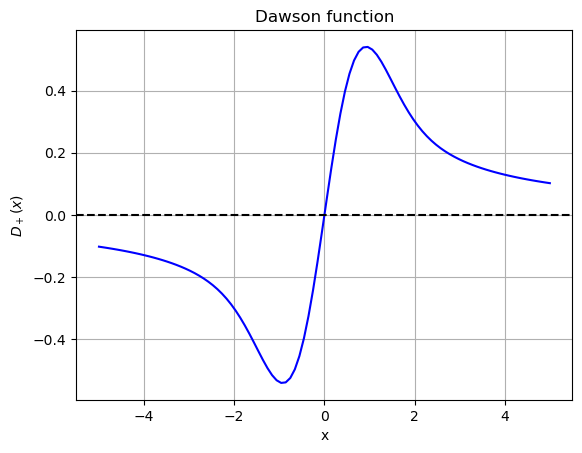

In [9]:
# Plot the function from -5 to 5
x = np.linspace(-5, 5, 100)
y = [DawsonF(xi) for xi in x]
plt.plot(x, y, label="DawsonF(x)", color="blue", linestyle="-")
plt.axhline(0, color="black", linestyle="--")
plt.title("Dawson function")
plt.xlabel("x")
plt.ylabel("${D_+}(x)$")
plt.grid()
plt.show()

The derivative of Dawson function can be computed explicitly by differentiating its defition:
$$
D_{+}'(x) = 1 - 2x D_+(x).
$$

This expression can be used to verify the accuracy of automatic differentiation

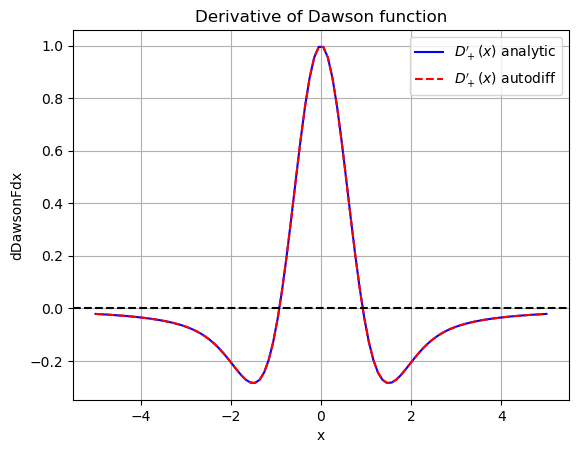

In [10]:
from jax import jvp

# Analytic derivative
def dDawsonFdx(x):
    return 1. - 2. * x * DawsonF(x)

# Forward mode AD
def dDawsonFdx_auto_forw(x): 
    return dfdx_auto_forward(DawsonF, x)
# Reverse mode AD
def dDawsonFdx_auto_reve(x): 
    return dfdx_auto_reverse(DawsonF, x)

# Compute and plot both derivatives from -5 to 5
x = np.linspace(-5, 5, 100)
df_vals = [dDawsonFdx(xi) for xi in x]
# Use forward mode
df_auto_vals = [dDawsonFdx_auto_forw(xi) for xi in x]

plt.plot(x, df_vals, label="${D_+'(x)}$ analytic", color="blue", linestyle="-")
plt.plot(x, df_auto_vals, label="${D_+'(x)}$ autodiff", color="red", linestyle="--")
plt.axhline(0, color="black", linestyle="--")
plt.title("Derivative of Dawson function")
plt.xlabel("x")
plt.ylabel("dDawsonFdx")
plt.legend()
plt.grid()
plt.show()

Timing the performance

In [11]:
%%time

# Timing the autodiff derivative forward mode
x = np.linspace(-5, 5, 100)
df_auto = [dDawsonFdx_auto_forw(xi) for xi in x]
print("Done")

Done
CPU times: user 2.11 s, sys: 33.9 ms, total: 2.14 s
Wall time: 2.14 s


In [12]:
%%time

# Timing the autodiff derivative reverse mode
x = np.linspace(-5, 5, 100)
df_auto = [dDawsonFdx_auto_reve(xi) for xi in x]
print("Done")

Done
CPU times: user 5.77 s, sys: 128 ms, total: 5.9 s
Wall time: 5.98 s


### MyGrad

Now let us try MyGrad from https://github.com/rsokl/MyGrad

In [13]:
import mygrad as mg

def f(x):
    return x**3 - 2*x**2 + x - 1

def df(x):
    return 3 * x**2 - 4 * x + 1

def dfdx_mygrad(func, x):
    xx = mg.Tensor(x)
    y = func(xx)
    y.backward()
    return xx.grad

print(f"{'x':>3s} {'f(x)':>10s} {'df/dx_analyt':>15s} {'df/dx_ad_mygrad':>15s}")
x_values = np.arange(0, 3, 0.2)
for x in x_values:
    print(f"{x:3.1f} {f(x):10.4f} {df(x):15.4f} {dfdx_mygrad(f,x):15.4f}")

  x       f(x)    df/dx_analyt df/dx_ad_mygrad
0.0    -1.0000          1.0000          1.0000
0.2    -0.8720          0.3200          0.3200
0.4    -0.8560         -0.1200         -0.1200
0.6    -0.9040         -0.3200         -0.3200
0.8    -0.9680         -0.2800         -0.2800
1.0    -1.0000          0.0000          0.0000
1.2    -0.9520          0.5200          0.5200
1.4    -0.7760          1.2800          1.2800
1.6    -0.4240          2.2800          2.2800
1.8     0.1520          3.5200          3.5200
2.0     1.0000          5.0000          5.0000
2.2     2.1680          6.7200          6.7200
2.4     3.7040          8.6800          8.6800
2.6     5.6560         10.8800         10.8800
2.8     8.0720         13.3200         13.3200


### Dawson function

In [14]:
from mygrad import exp

def DawsonF(x):
  def fint(t):
    return exp(t**2)
  x2 = x**2
  gaussx, gaussw = gaussxwab32(0,x)
  return exp(-x2) * integrate_quadrature(fint, (gaussx, gaussw))

print(dfdx_mygrad(DawsonF, 1.0))

-0.07615901382553736


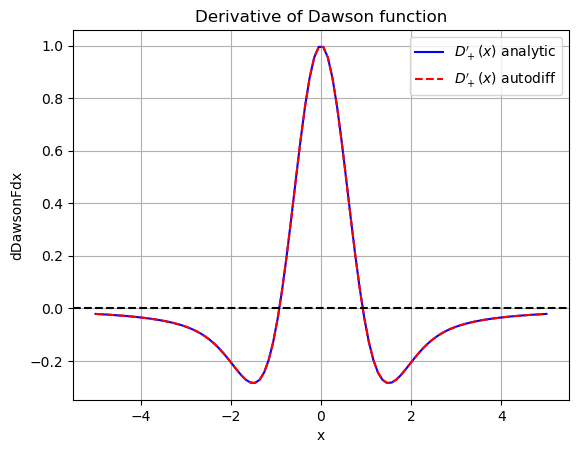

In [15]:
# Analytic derivative
def dDawsonFdx(x):
    return 1. - 2. * x * DawsonF(x)

dDawsonFdx_mg_reve = lambda x: dfdx_mygrad(DawsonF, x)

# Plot both derivatives from -5 to 5
x = np.linspace(-5, 5, 100)
df_vals = [dDawsonFdx(xi) for xi in x]
df_auto_vals = [dDawsonFdx_mg_reve(xi) for xi in x]

plt.plot(x, df_vals, label="${D_+'(x)}$ analytic", color="blue", linestyle="-")
plt.plot(x, df_auto_vals, label="${D_+'(x)}$ autodiff", color="red", linestyle="--")
plt.axhline(0, color="black", linestyle="--")
plt.title("Derivative of Dawson function")
plt.xlabel("x")
plt.ylabel("dDawsonFdx")
plt.legend()
plt.grid()
plt.show()

In [16]:
%%time

# Timing the MyGrad autodiff derivative reverse mode
x = np.linspace(-5, 5, 100)
df_auto = [dfdx_mygrad(DawsonF,xi) for xi in x]
# df_auto = dfdx_mygrad(DawsonF,x)
print("Done")

Done
CPU times: user 313 ms, sys: 8.88 ms, total: 322 ms
Wall time: 321 ms
